In [1]:
import sys
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
from pudl import constants, settings, models, ferc1, eia923, pudl

In [9]:
#%load_ext autoreload
%autoreload 1
%aimport pudl
%aimport pudl.ferc1
%matplotlib inline

In [46]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [49]:
def smallwind(wind_plants,f1_engine):
    small_plant = pd.read_sql('''SELECT p.respondent_id, r.respondent_name, p.report_year, p.plant_name,\
                                p.yr_constructed, p.capacity_rating, p.net_demand, p.net_generation, p.plant_cost,\
                                p.plant_cost_mw, p.operation, p.expns_fuel, p.expns_maint, p.kind_of_fuel,\
                                p.fuel_cost\
                                FROM f1_gnrt_plant p JOIN f1_respondent_id r ON r.respondent_id=p.respondent_id''',f1_engine)

    wind_name = small_plant[small_plant['plant_name'].str.contains("wind", case=False)]
    wind_fuel = small_plant[small_plant['kind_of_fuel'].str.contains("wind", case=False)]
    wind_plants = pd.concat([wind_plants,wind_name,wind_fuel])
    wind_plants.drop_duplicates(inplace=True)
    wind_plants = wind_plants[(wind_plants.yr_constructed!='')]
    return(wind_plants)

In [50]:
wind_plants = pd.DataFrame()
for year in range(2004,2016):
    print('Initializing FERC Form 1 DB for {}'.format(year))
    ferc1.init_db(refyear=2015,years=[year,])
    f1_engine = create_engine('postgresql://catalyst@localhost:5432/ferc1')
    wind_plants = smallwind(wind_plants, f1_engine)

Initializing FERC Form 1 DB for 2004
Initializing FERC Form 1 DB for 2005
Initializing FERC Form 1 DB for 2006
Initializing FERC Form 1 DB for 2007
Initializing FERC Form 1 DB for 2008
Initializing FERC Form 1 DB for 2009
Initializing FERC Form 1 DB for 2010
Initializing FERC Form 1 DB for 2011
Initializing FERC Form 1 DB for 2012
Initializing FERC Form 1 DB for 2013
Initializing FERC Form 1 DB for 2014
Initializing FERC Form 1 DB for 2015


In [54]:
wind_plants.to_csv('ferc1_wind_plants_2004-2015.csv')

In [19]:
pudl_engine = create_engine('postgresql://catalyst@localhost:5432/pudl_sandbox')

In [13]:
f1_fuel = pd.read_sql('''SELECT respondent_id, report_year, plant_name, fuel, fuel_unit, fuel_quantity,\
                                fuel_avg_heat, fuel_cost_delvd, fuel_cost_burned, fuel_cost_btu, fuel_cost_kwh,\
                                fuel_generaton \
                                FROM f1_fuel WHERE plant_name <> '' AND fuel NOT IN ('Total','') ''',f1_engine)

In [14]:
f1_fuel.columns

Index(['respondent_id', 'report_year', 'plant_name', 'fuel', 'fuel_unit',
       'fuel_quantity', 'fuel_avg_heat', 'fuel_cost_delvd', 'fuel_cost_burned',
       'fuel_cost_btu', 'fuel_cost_kwh', 'fuel_generaton'],
      dtype='object')

In [18]:
f1_fuel.sample(10)

,respondent_id,report_year,plant_name,fuel,fuel_unit,fuel_quantity,fuel_avg_heat,fuel_cost_delvd,fuel_cost_burned,fuel_cost_btu,fuel_cost_kwh,fuel_generaton
908,195,2015,Total - Pulliam,Oil,Barrels,0.0,0.0,0.000,0.000,0.000,0.000,0.000
181,294,2015,Holland,NG,mmBtu,1932634.0,1.0,3.010,3.010,3.010,0.025,8401.000
145,186,2015,Possum Point,Gas,mcf,486102.0,1058.0,5.090,5.450,5.150,0.069,0.000
450,145,2015,Fruita,Oil,bbls,146.0,136765.0,117.680,117.680,20.500,0.000,0.000
436,145,2015,Hayden,Coal,tons,704321.0,11658.0,45.030,48.440,2.130,0.025,11841.590
1407,144,2015,GALLAGHER,Oil,Barrels,21594.0,137000.0,80.201,86.709,15.069,0.004,0.000
1238,130,2015,MUSTANG,Gas,MCF,1295042.0,1037000.0,0.000,35.958,0.033,0.396,11832.000
1115,51,2015,Asbury,Tires,Tons,2098.0,13936.0,35.949,35.949,1.290,0.014,10502.686
782,56,2015,Turkey Point 5,Oil,Barrels,11890.0,137476.0,60.517,60.517,10.481,0.000,0.000
893,195,2015,Pulliam 5,Oil,Barrels,0.0,0.0,0.000,0.000,0.000,0.000,0.000


In [82]:
fuel_plant = pd.read_sql('''SELECT DISTINCT r.respondent_id, r.respondent_name, f.plant_name, f.fuel
                            FROM f1_respondent_id r JOIN f1_fuel f ON f.respondent_id = r.respondent_id
                            WHERE f.plant_name <> '' AND f.fuel NOT IN ('Total','') ''',f1_engine)
fuel_plant = fuel_plant.sort_values('respondent_id')
fuel_plant['fuel']=pudl.ferc1.f1_cleanstrings(fuel_plant['fuel'],pudl.ferc1.f1_fuel_strings, unmapped=np.nan)


In [83]:
fuel_plant.columns

Index(['respondent_id', 'respondent_name', 'plant_name', 'fuel'], dtype='object')

In [5]:
f1_respondents = pd.read_sql('''SELECT DISTINCT respondent_id, respondent_name from f1_respondent_id''', f1_engine)
f1_plants = pd.read_sql('''SELECT DISTINCT r.respondent_id, r.respondent_name, f.plant_name
                           FROM f1_respondent_id r JOIN f1_fuel f on f.respondent_id = r.respondent_id
                           WHERE f.plant_name <> '' ''',f1_engine)
f1_fuel = pd.read_sql('''SELECT * from f1_fuel''', f1_engine)
f1_respondents.to_csv('f1_respondents.csv')
f1_plants.to_csv('f1_plants.csv')

In [16]:
f1_respondents[(f1_respondents['respondent_id']>450)]

,respondent_id,respondent_name
9,452,AEP Generation Resources Inc.
117,453,"Transource Missouri, LLC"
184,513,"4C Acquisition, LLC"
235,999,{Test Company - A}
273,998,{Test Company - B1}
293,454,"Entergy Louisiana, LLC"
326,455,ITC Interconnection LLC
336,512,"Transource West Virginia, LLC"
362,451,Smoky Mountain Transmission LLC


In [13]:
fuel_plant.plant_name[(fuel_plant['plant_name']=="Comanche")]

81     Comanche
10     Comanche
139    Comanche
Name: plant_name, dtype: object

In [20]:
df = pd.read_sql('''SELECT f.respondent_id, f.plant_name, f.fuel, f.fuel_cost_kwh,
                           s.plant_hours, s.net_generation, s.expns_fuel, s.tot_prdctn_expns,
                           s.expns_kwh, s.tot_capacity
                    FROM f1_fuel f JOIN f1_steam s USING (respondent_id, plant_name)
                    WHERE f.plant_name <> '' AND f.fuel_cost_kwh > 0.0 ''', f1_engine)
df['fuel']=pudl.ferc1.f1_cleanstrings(df['fuel'],pudl.ferc1.f1_fuel_strings, unmapped=np.nan)
df['capacity_factor']= df.net_generation/(df.tot_capacity*1000*8760)
df['expns_mwh']=df['expns_kwh']*1000
coal = df[(df.fuel=='coal')]
gas = df[(df.fuel=='gas')]

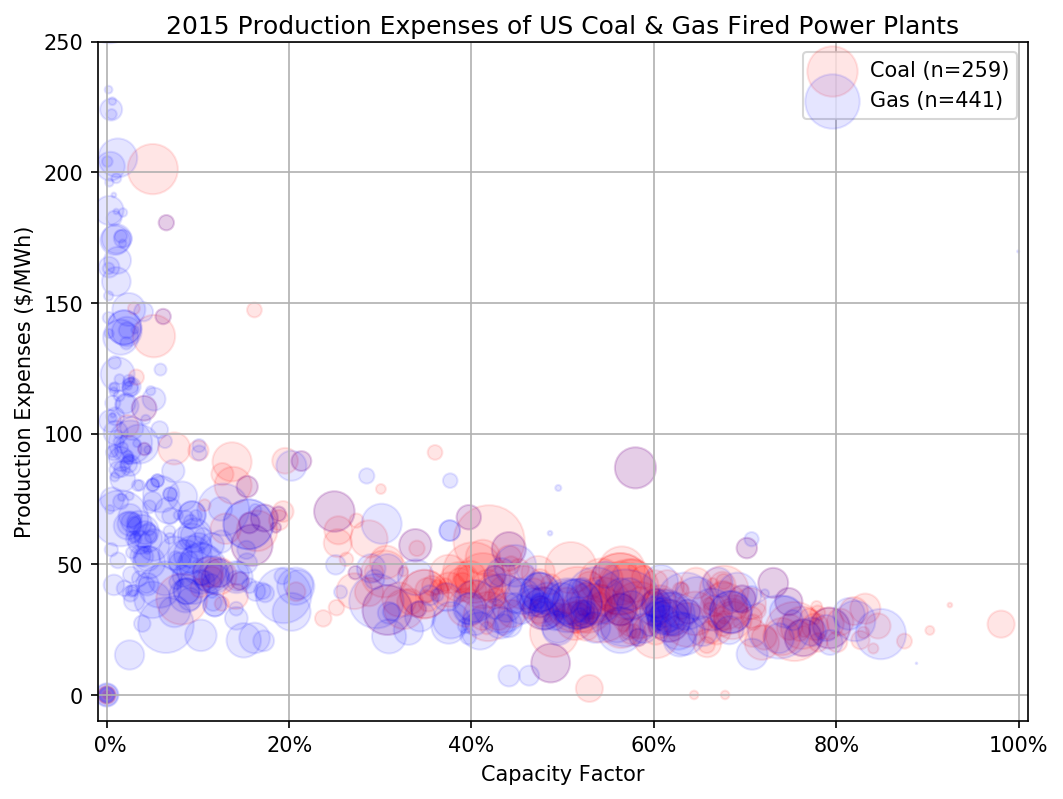

In [28]:
fig = plt.figure(figsize=(8,6),dpi=150)
plt.xlim(-0.01,1.01)
plt.ylim(-10,250)
plt.grid(True)
plt.title("2015 Production Expenses of US Coal & Gas Fired Power Plants")
plt.xlabel("Capacity Factor")
plt.ylabel("Production Expenses ($/MWh)")
plt.scatter(coal.capacity_factor, coal.expns_mwh, s=coal.tot_capacity/3,
            c='red',alpha=0.1, label='Coal (n={})'.format(coal.shape[0]))
plt.scatter(gas.capacity_factor, gas.expns_mwh, s=gas.tot_capacity/3,
            c='blue',alpha=0.1, label='Gas (n={})'.format(gas.shape[0]))
plt.legend()
ax = fig.axes[0]
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0%}'.format(x) for x in vals])

In [18]:
for yr in np.arange(1994,2015):
    yr1 = pd.DataFrame(dbfread.DBF(glob.glob('data/ferc/form1/{}/*/FORM1/working/F1_1.DBF'.format(yr))[0], load=True).records)
    yr2 = pd.DataFrame(dbfread.DBF(glob.glob('data/ferc/form1/{}/*/FORM1/working/F1_1.DBF'.format(yr+1))[0], load=True).records)
    added = set(yr2['RESPONDENT'].unique()).difference(set(yr1['RESPONDENT'].unique()))
    removed = set(yr1['RESPONDENT'].unique()).difference(set(yr2['RESPONDENT'].unique()))
    if len(added) > 0: print('ids added between {} and {}: {}'.format(yr,yr+1,added))
    if len(removed) > 0: print('ids removed between {} and {}: {}'.format(yr,yr+1,removed))

ids added between 1997 and 1998: {305, 306, 307, 308, 309}
ids removed between 1998 and 1999: {305, 306, 307, 308, 309}
ids added between 1999 and 2000: {320, 433, 432, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319}
ids removed between 2000 and 2001: {320, 432, 433, 311, 312, 313, 314, 315, 316, 317, 318, 319}
ids removed between 2001 and 2002: {305, 306, 307, 308, 309, 310}
ids added between 2002 and 2003: {305, 306, 307, 308, 309, 310}
ids added between 2004 and 2005: {444, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 311, 312, 313, 314, 320, 315, 316, 317, 318, 319, 445, 446}
ids added between 2013 and 2014: {448, 321, 450, 451, 449, 452, 453, 447}
ids added between 2014 and 2015: {512, 513, 322, 454, 455}
ids removed between 2014 and 2015: {291, 273, 242, 180, 278, 280}


In [25]:
df[(df['respondent_id']==145)][['respondent_id','plant_name']]

,respondent_id,plant_name
299,145,"Cherokee 3,4"
300,145,"Cherokee 5, 6, & 7"
301,145,Comanche
302,145,Craig
303,145,Hayden
304,145,Pawnee
305,145,Valmont 5
306,145,Alamosa
307,145,Fort Lupton
308,145,Fruita


In [72]:
#maren = pd.read_sql('''SELECT s.plant_name, s.tot_capacity, s.net_generation, s.cost_of_plant_to,
#                              s.cost_per_kw, s.expns_fuel, s.tot_prdctn_expns, s.expns_kwh, f.fuel, f.fuel_unit,
#                              f.fuel_quantity, f.fuel_cost_burned, f.fuel_cost_delvd, f.fuel_cost_kwh
#                       FROM f1_fuel f JOIN f1_steam s USING (respondent_id, plant_name) 
#                       WHERE f.respondent_id=145 AND f.plant_name <> '' AND f.fuel <> ''
#                             AND f.fuel_cost_delvd > 0 ''', f1_engine)
maren = pd.read_sql('''SELECT * FROM f1_steam JOIN f1_fuel USING (respondent_id, plant_name)
                       WHERE respondent_id=145 AND plant_name <> '' AND fuel <> '' ''', f1_engine)
#maren['fuel']=pudl.ferc1.f1_cleanstrings(maren['fuel'],pudl.ferc1.f1_fuel_strings, unmapped=np.nan)
#maren['fuel_unit']=pudl.ferc1.f1_cleanstrings(maren['fuel'],pudl.ferc1.f1_fuel_unit_strings, unmapped=np.nan)
maren['capacity_factor']= maren.net_generation/(maren.tot_capacity*1000*8760)
maren['expns_nonfuel']=maren['tot_prdctn_expns']-maren['expns_fuel']
maren['expns_fuel_mwh']=1000*maren['expns_fuel']/maren.net_generation
maren['expns_nonfuel_mwh']=1000*maren.expns_nonfuel/maren.net_generation
#maren['fuel_cost_mwh'] = maren['fuel_cost_kwh']*1000
#maren['fuel_cost_calc_burned'] = maren['fuel_cost_burned']*maren['fuel_quantity']
#maren['fuel_cost_calc_delvd'] = maren['fuel_cost_delvd']*maren['fuel_quantity']
#maren['fuel_discrepancy'] = abs(maren.fuel_cost_calc_burned - maren.expns_fuel)/maren.expns_fuel

In [76]:
x = maren[['plant_name','capacity_factor','expns_fuel_mwh','expns_nonfuel_mwh']].drop_duplicates()

In [79]:
x

,plant_name,capacity_factor,expns_fuel_mwh,expns_nonfuel_mwh
0,"Cherokee 3,4",0.529287,0.820893,1.671561
3,"Cherokee 5, 6, & 7",0.202504,66.778416,20.945707
6,Comanche,0.490691,16.685878,7.074131
9,Craig,0.693286,19.934668,7.766966
12,Hayden,0.332696,25.256961,10.422515
15,Pawnee,0.708325,16.150027,7.682462
17,Valmont 5,0.629585,32.089172,7.953279
19,Zuni,-0.001883,-39.993533,-2195.409863
21,Alamosa,0.007681,87.449372,28.508229
23,Fort Lupton,0.003625,104.252109,172.308029


In [78]:
x.to_csv('ferc_summary.csv')

In [102]:
small_plants = pd.read_sql('''SELECT DISTINCT r.respondent_id, r.respondent_name, p.plant_name, p.kind_of_fuel, p.capacity_rating
                            FROM f1_respondent_id r JOIN f1_gnrt_plant p ON r.respondent_id = p.respondent_id
                            WHERE p.capacity_rating > 5.0''', f1_engine)

In [103]:
small_plants.shape

(204, 5)

In [106]:
small_plants.to_csv('small_plant_matching.csv')

In [107]:
hydro_plants = pd.read_sql('''SELECT DISTINCT r.respondent_id, r.respondent_name, p.plant_name, p.plant_kind,
                                              p.tot_capacity
                              FROM f1_respondent_id r JOIN f1_hydro p ON r.respondent_id = p.respondent_id
                              WHERE p.tot_capacity > 5.0''', f1_engine)

In [112]:
hydro_plants.to_csv('hydro_plant_matching.csv')

In [113]:
pumped_storage = pd.read_sql('''SELECT DISTINCT r.respondent_id, r.respondent_name, p.plant_name, p.plant_kind,
                                              p.tot_capacity
                              FROM f1_respondent_id r JOIN f1_pumped_storage p ON r.respondent_id = p.respondent_id
                              WHERE p.tot_capacity > 5.0''', f1_engine)

In [117]:
pumped_storage

,respondent_id,respondent_name,plant_name,plant_kind,tot_capacity
0,5,THE ALLEGHENY GENERATING COMPANY,Bath County,Conventional,995.0
1,6,Appalachian Power Company,Smith Mountain,OUTDOOR,647.0
2,41,Consumers Energy Company,LUDINGTON(CECo%),Conventional,1038.0
3,41,Consumers Energy Company,LUDINGTON(Total),Conventional,2036.0
4,44,DTE Electric Company,Ludington (DTE%),Conventional,998.0
5,44,DTE Electric Company,Ludington (Total),Conventional,2036.0
6,45,"Duke Energy Carolinas, LLC",Bad Creek,Outdoor,1296.0
7,45,"Duke Energy Carolinas, LLC",Jocassee,Outdoor,774.0
8,57,Georgia Power Company,ROCKY MOUNTAIN,,215.0
9,57,Georgia Power Company,WALLACE DAM,SEMI-OUTDOOR,209.0


In [118]:
pumped_storage.to_csv('pumped_storage_matching.csv')

In [ ]:
wind_plants = pd.DataFrame()
def smallwind():
    small_plant = pd.read_sql('''SELECT p.respondent_id, r.respondent_name, p.report_year, p.plant_name,\
                                p.yr_constructed, p.capacity_rating, p.net_demand, p.net_generation, p.plant_cost,\
                                p.plant_cost_mw, p.operation, p.expns_fuel, p.expns_maint, p.kind_of_fuel,\
                                p.fuel_cost\
                                FROM f1_gnrt_plant p JOIN f1_respondent_id r ON r.respondent_id=p.respondent_id''',f1_engine)

    wind_name = f1_small_plant[f1_small_plant['plant_name'].str.contains("wind", case=False)]
    wind_fuel = f1_small_plant[f1_small_plant['kind_of_fuel'].str.contains("wind", case=False)]
    wind_plants = pd.concat([wind_plants,wind_name,wind_fuel])
    wind_plants.drop_duplicates(inplace=True)
    wind_plants = wind_plants[(wind_plants.yr_constructed!='')]

wind_plants.to_csv('ferc1_wind_plants.csv')